## Configure osmnx

In [2]:
import osmnx as ox
ox.config(log_console = True, data_folder = 'data')
graph = ox.load_graphml('nerails_simplified.graphml')

## Node centrality

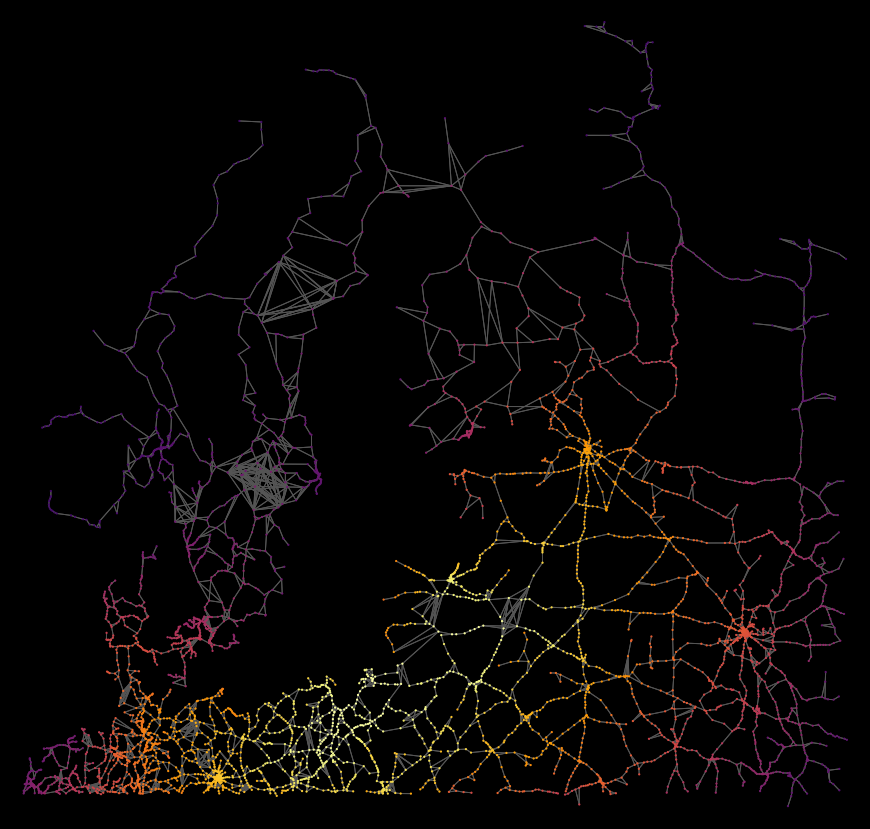

In [8]:
# https://github.com/gboeing/osmnx-examples/blob/master/notebooks/08-example-line-graph.ipynb

import numpy as np
import networkx as nx
import scipy.sparse
import scipy.sparse.csgraph
import pandas as pd

#node_centrality = nx.closeness_centrality(G)
# networkx implementation is superrrr slow, source of this code is from
# https://medium.com/@pasdan/closeness-centrality-via-networkx-is-taking-too-long-1a58e648f5ce

G = graph
G = G.to_undirected()

A = nx.adjacency_matrix(graph, nodelist=None, weight='length').tolil()
D = scipy.sparse.csgraph.floyd_warshall(A, directed=False, unweighted=False)

n = D.shape[0]
closeness_centrality = {}
for r in range(0, n):
    
    cc = 0.0
    
    possible_paths = list(enumerate(D[r, :]))
    shortest_paths = dict(filter( \
        lambda x: not x[1] == np.inf, possible_paths))
    
    total = sum(shortest_paths.values())
    n_shortest_paths = len(shortest_paths) - 1.0
    if total > 0.0 and n > 1:
        s = n_shortest_paths / (n - 1)
        cc = (n_shortest_paths / total) * s
    closeness_centrality[list(graph.nodes)[r]] = cc
    
node_centrality = closeness_centrality

df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(graph, bgcolor='k', node_size=5, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1, edge_alpha=1, fig_height=15)